In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [ ]:
len(words)

32033

In [ ]:
#build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [ ]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [78]:
from typing import Any


class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) #/ fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
        self.W2 = torch.ones((fan_out))
        self.b2 = torch.zeros(fan_out)

    def __call__(self, x):
        self.out = x @ self.weight
        self.out * self.W2
        if self.bias is not None:
            self.out += self.bias
        self.out += self.b2
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
    def set_parameters(self, gamma, beta):
        self.W2 = gamma / gamma.sum()
        self.b2 = beta
class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        #parameters trained with backprop
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        #buffers trained with a running momentum update
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x) -> Any:
        #calculates the forward pass
        if self.training:
            xmean = x.mean(0, keepdims=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        #update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * xmean
        return self.out
    
    def parameters(self):
        return[self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x) -> Any:
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []
    

# n_embd = 10 # the dimensionality of the character embedding vectors
# n_hidden = 100 # the number of neurons in the hidden layer of the MLP

# C = torch.randn((vocab_size, n_embd))
# layers = [
#   Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
# ]
# # layers = [
# #   Linear(n_embd * block_size, n_hidden), Tanh(),
# #   Linear(           n_hidden, n_hidden), Tanh(),
# #   Linear(           n_hidden, n_hidden), Tanh(),
# #   Linear(           n_hidden, n_hidden), Tanh(),
# #   Linear(           n_hidden, n_hidden), Tanh(),
# #   Linear(           n_hidden, vocab_size),
# # ]

# with torch.no_grad():
#     # last layer make less confident
#     layers[-1].gamma *= 0.1
#     # all other layers apply gain
#     for layer in layers[:-1]:
#         if isinstance(layer, Linear):
#             layer.weight *= 1

# parameters = [C] + [p for layer in layers for p in layer.parameters()]
# print(sum(p.nelement() for p in parameters)) # number pf parameters in total
# for p in parameters:
#     p.requires_grad = True


In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []
print(layers[-1].beta)
for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 1 if i < 100000 else 0.1
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 1000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.], requires_grad=True)
      0/ 200000: 3.2958
   1000/ 200000: 2.8744
tensor([ 1.9205,  1.8265, -0.6438, -0.0908,  0.2651,  1.4290, -1.4507, -0.7790,
         0.4673,  1.4434, -0.4852,  0.0564,  0.8985,  0.1888,  1.3556,  0.5987,
        -1.7694, -2.4391,  0.7670,  0.5004,  0.2349, -0.3988, -0.5986, -1.4882,
        -1.9712,  0.6822, -0.5194], requires_grad=True)


layer 2 (      Tanh): mean +0.00, std 0.63, saturated: 2.78%
layer 5 (      Tanh): mean -0.00, std 0.63, saturated: 2.81%


Text(0.5, 1.0, 'activation distribution')

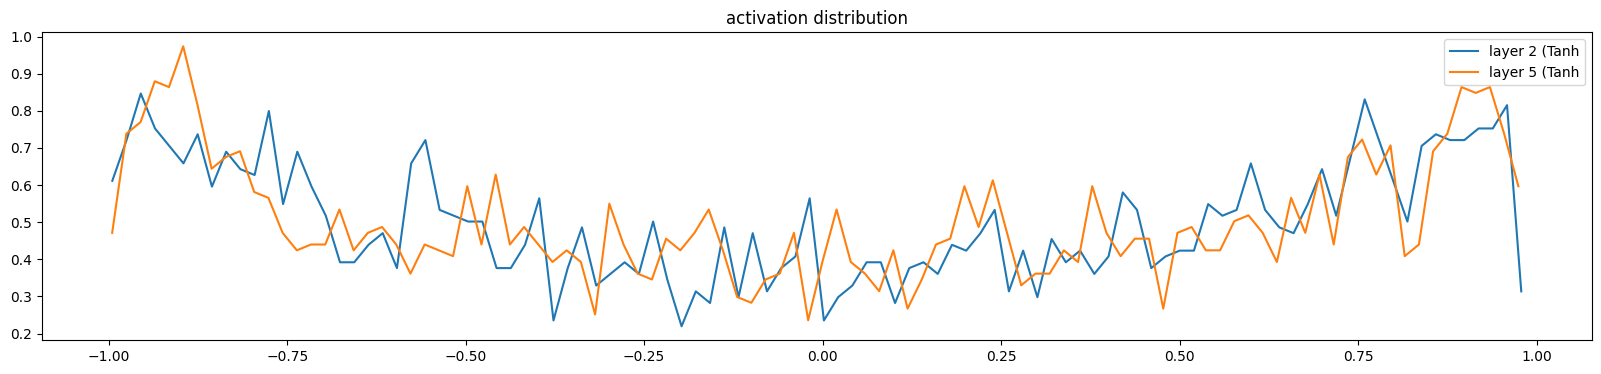

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000000, std 5.408922e-04
layer 5 (      Tanh): mean +0.000000, std 4.668743e-04


Text(0.5, 1.0, 'gradient distribution')

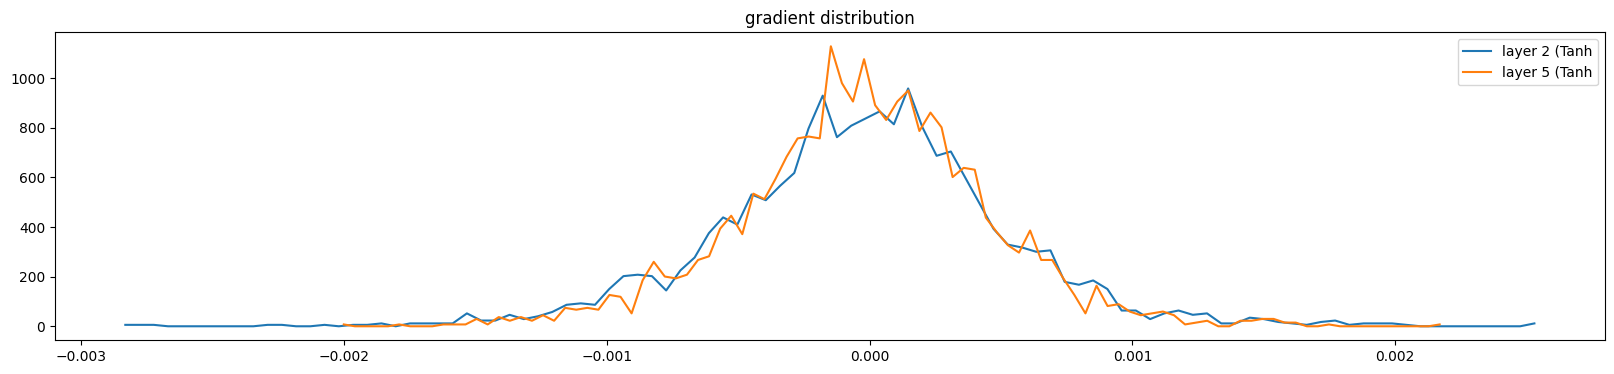

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

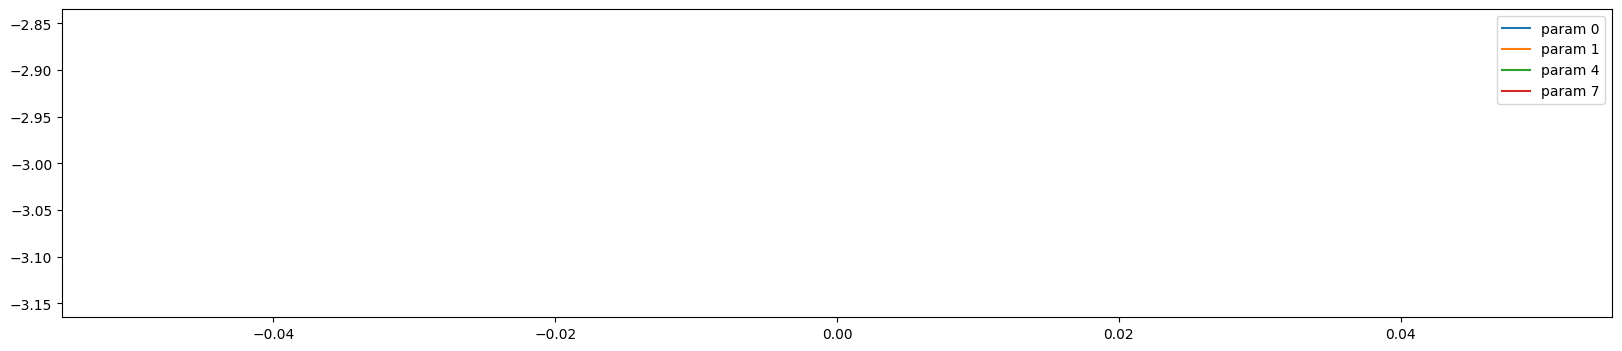

In [ ]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [79]:
# exersize

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP

C = torch.randn((vocab_size, n_embd))
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]

with torch.no_grad():
    # last layer make less confident
    layers[-1].gamma *= 0.1
    # all other layers apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number pf parameters in total
for p in parameters:
    p.requires_grad = True

16424


In [80]:
# same optimization as last time
max_steps = 2000
batch_size = 32
lossi = []
ud = []
for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 1 if i < 100000 else 0.1
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

      0/   2000: 3.3094


In [81]:
# forward pass
emb = C[Xdev]
x = emb.view(emb.shape[0], -1)
for layer in layers:
    x = layer(x)
print(x)
loss = F.cross_entropy(x, Ydev)
loss

tensor([[-2.0279,  1.6464,  1.1391,  ..., -1.3447, -0.1495,  0.3531],
        [-1.0480,  0.1048,  0.3662,  ..., -1.6203,  0.5761, -0.3223],
        [-0.3559,  3.2194, -0.8942,  ..., -1.8282,  1.2365,  0.0175],
        ...,
        [ 2.2166,  2.3735, -0.2010,  ..., -1.7946,  0.1333, -0.7370],
        [ 2.5005,  4.1225, -2.1280,  ..., -1.8674,  3.3418, -0.6522],
        [ 3.2843,  0.3617, -0.3224,  ..., -0.9262,  0.4601, -1.1718]],
       grad_fn=<AddBackward0>)


tensor(2.3812, grad_fn=<NllLossBackward0>)

In [82]:
# forward pass
i = 1
emb = C[Xdev]
x = emb.view(emb.shape[0], -1)
for layer in layers:
    if isinstance(layer, (BatchNorm1d)):
        print('b:', i)
    else:
        if isinstance(layer, Linear):
            print('l:', i)
            layer.set_parameters(layers[i].running_mean, layers[i].running_var)
        x = layer(x)
    i += 1
print(x)
loss = F.cross_entropy(x, Ydev)
loss


l: 1
b: 2
l: 4
b: 5
l: 7
b: 8
tensor([[ 36.8809,  17.7262,  12.8496,  ...,   6.9020, -21.4423,  -8.0057],
        [ 35.4455,  10.5297,   2.8104,  ...,  15.5067, -22.3658,  -6.7877],
        [ 34.7968,   6.6092,  25.2956,  ..., -18.4968,   5.8342,  27.6701],
        ...,
        [ 12.1341,  14.7074,  15.3390,  ...,   3.8403, -15.9172,  -5.9018],
        [ -5.7520,   5.8745, -25.7555,  ..., -12.9896,   4.0305,  -8.1053],
        [-32.2606,  39.5876, -24.2595,  ..., -20.9972, -29.2747, -32.8979]],
       grad_fn=<AddBackward0>)


tensor(34.3394, grad_fn=<NllLossBackward0>)